Counter({'c': 83996, 'b': 76703, 'd': 76032, 'a': 44341, 'e': 7353, 'g': 7126, 'f': 7015})


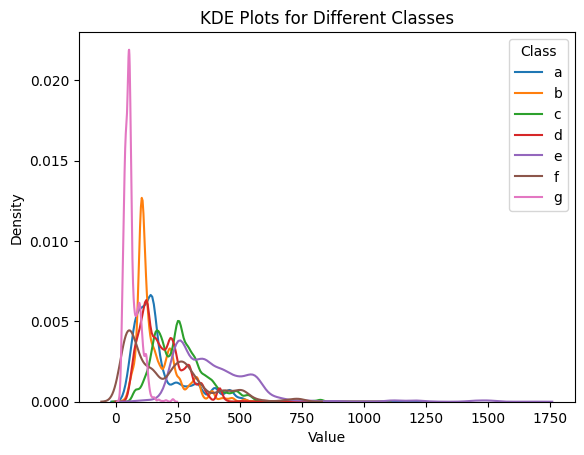

In [1]:
from Bio import SeqIO 
from collections import Counter

counter = Counter()
lengths = {}
for record in SeqIO.parse("tmp/astral.fasta", "fasta"):

    
    _class = record.description.split()[1][0]
    counter[_class] += 1

    if _class not in lengths:

        lengths[_class] = []

    lengths[_class].append(len(record.seq))
    

print(counter)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()

for class_ in lengths: 
    sns.kdeplot(lengths[class_], label=class_)

plt.title('KDE Plots for Different Classes')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(title='Class')

plt.show()